# 1. Import

In [4]:
from Init3 import *
db_path = search_and_initialise_db()
qc.experiments()

找到 7 個 .db 文件:
1. c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\PtTe2\005-2\005-2_2024-11-26_01.db
2. c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\PtTe2\006-1\006-1_2025-01-09_01.db
3. c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\PtTe2\009-1\009-1_2024-12-26_01.db
4. c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\PtTe2\009-2\009-2_2024-12-26_01.db
5. c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\PtTe2\018\018_2025-02-26_01.db
6. c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\PtTe2\018\018_2025-03-06_01.db
7. c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\PtTe2\019\019_2025-03-08_01.db
初始化數據庫: c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\PtTe2\019\019_2025-03-08_01.db


[IV#019_1kOhm#1@c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\PtTe2\019\019_2025-03-08_01.db
 ------------------------------------------------------------------------------------------------------------------
 1-results-1-appl_current,meas_voltage_K2-101,
 IV#019_1kOhm#2@c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\PtTe2\019\019_2025-03-08_01.db
 ------------------------------------------------------------------------------------------------------------------
 2-results-1-appl_current,meas_voltage_K2-101,
 IV#019_1kOhm#3@c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\PtTe2\019\019_2025-03-08_01.db
 ------------------------------------------------------------------------------------------------------------------
 3-results-1-appl_current,meas_voltage_K2-101,
 IV#019_1kOhm#4@c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\PtTe2\019\019_2025-03-08_01.db
 ----------------------------------------------

-1.044896776e-05 array 151


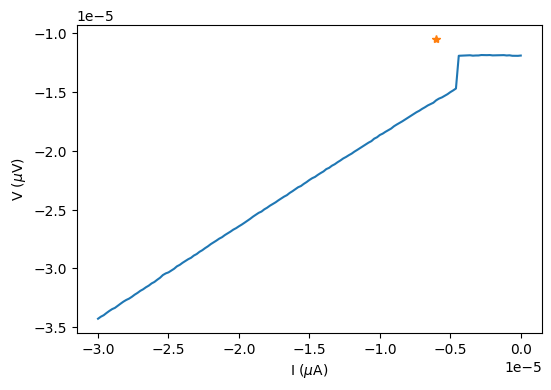

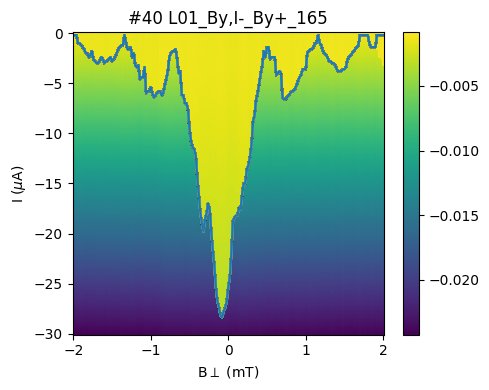

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import qcodes as qc

def analyze_and_plot_data(runid):
    # Load dataset
    dataset = qc.load_by_id(runid)

    # Extract parameters
    V = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
    By_field = dataset.get_parameter_data()['meas_voltage_K2']['y_field']
    I = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']

    # Determine the size of the gate array
    s = len(I)
    N = 1
    for i in range(s):
        if By_field[i] != By_field[i + 1]:
            break
        else:
            N += 1
            print('size of the gate array', N, end='\r')

    NI = N
    NB = s // N

    # Calculate DC Bias vs. field
    R_DC = V / (I[2] - I[1])
    R_DC = R_DC.reshape(NB, NI)
    R_DC = np.diff(R_DC, axis=1)
    I = I.reshape(NB, NI)
    By_field = By_field.reshape(NB, NI)
    V = V.reshape(NB, NI)

    # Save data to CSV files
    np.savetxt(f'L01_{runid}_By.csv', By_field, fmt='%s', delimiter=',')
    np.savetxt(f'L01_{runid}_I.csv', I, fmt='%s', delimiter=',')
    np.savetxt(f'L01_{runid}_V.csv', V, fmt='%s', delimiter=',')
    np.savetxt(f'L01_{runid}_R.csv', R_DC, fmt='%s', delimiter=',')

    # Load data from CSV files
    By = np.loadtxt(f'L01_{runid}_By.csv', delimiter=",")
    I = np.loadtxt(f'L01_{runid}_I.csv', delimiter=",")
    V = np.loadtxt(f'L01_{runid}_V.csv', delimiter=",")
    R = np.loadtxt(f'L01_{runid}_R.csv', delimiter=",")

    # Plot I-V curve with DC offset
    plt.figure(figsize=(6, 4))
    DCoff = np.mean(V[54, 40:90])
    plt.plot(I[54], V[54] + DCoff)
    plt.plot(I[54, 30], DCoff, '*')
    plt.xlabel('I ($\mu$A)')
    plt.ylabel('V ($\mu$V)')
    print(DCoff)

    # Calculate V offset due to slope
    saiz = np.shape(V)
    Is = np.zeros(saiz[0])
    Ir = np.zeros(saiz[0])
    fV = np.zeros((saiz[0], saiz[1]))

    for i in range(saiz[0]):
        for j in range(1, saiz[1]):
            DCoff = np.mean(V[70, 5:15])
            if V[i, j] - DCoff > -1e-8:
                Is[i] = I[i, j]
                break

        for j in range(1, saiz[1]):
            DCoff = np.mean(-V[120, 10:15])
            if -V[i, j] - DCoff < 1e-6:
                Ir[i] = I[i, j]
                break

    # Analyze resistance
    for i in range(5, 200):
        for j in range(5, 150):
            if R[i, j] > 1.4:
                Is[i] = I[i, j]
                break

    # Plot heatmap
    fig, ax0 = plt.subplots(ncols=1, figsize=(5, 4))
    fig.subplots_adjust(hspace=55)
    Arange = 0
    Brange = 400
    im = ax0.pcolormesh(By[Arange:Brange, :] / 1e-3, I[Arange:Brange, :] / 1e-6, V[Arange:Brange, :] / 1e-3, cmap='viridis')
    fig.colorbar(im, ax=ax0)
    ax0.set_title(f'#40 L01_By,I-_By+_{runid}')
    ax0.set(xlabel='B$\perp$ (mT)', ylabel='I ($\mu$A)')

    plt.plot(By[Arange:Brange, :] / 1e-3, Is[Arange:Brange] / 1e-6)

    # Save Is data to CSV
    np.savetxt(f'Is_{runid}.csv', Is, fmt='%s', delimiter=',')

    fig.tight_layout()
    plt.savefig(f"#40 L01_By,I-_By+_{runid}")
    plt.show()

# Example usage
runid = 165
analyze_and_plot_data(runid)

In [ ]:
fig = IcFinder([156,157], plot_against_param='y_field', label_param_path=None)

In [ ]:
fig = plot_combined_iv_dvdi(107)

# 3. Heatmap

In [2]:
fig1, fig2 = plot_heatmaps(185)
clear_output()
fig1.show()
fig2.show()

In [ ]:
fig1, fig2 = plot_heatmaps(130)
clear_output()
fig1.show()
fig2.show()

In [41]:
df.describe()

y_field  appl_current  meas_voltage_K2         dV_dI
count  30351.00000  30351.000000     3.035100e+04  30351.000000
mean       0.00000     -0.000015    -1.131197e-05      0.745398
std        0.00116      0.000009     7.332321e-06      1.784642
min       -0.00200     -0.000030    -2.423879e-05     -0.300750
25%       -0.00100     -0.000023    -1.782800e-05      0.646831
50%        0.00000     -0.000015    -1.126462e-05      0.746675
75%        0.00100     -0.000007    -3.926746e-06      0.806525
max        0.00200      0.000000    -8.409139e-07     47.886185

In [3]:
def plot_hist_resistance(runid):
    # 獲取數據集信息和參數單位
    exp_name, sample_name, param_units, start_time, completed_time, run_time, display_time = get_dataset_info(runid)
    
    # 獲取數據框
    setpoint_params, dependent_param, param_info, df = info_df(runid)
    
    # 獲取參數名稱
    params = list(df.keys())
    
    # 檢查參數
    if len(params) < 3:
        raise ValueError("DataFrame 必須至少包含 3 個列 (x, y, z)")
    
    # 使用原始參數名稱
    x_param = params[0]  # y_field
    y_param = params[1]  # appl_current
    v_param = params[2]  # meas_voltage_K2
    
    # 如果有第四個參數，假設為 dV/dI
    dvdi_param = params[3] if len(params) >= 4 else None
    
    # 使用從數據集獲取的單位，如果未找到則使用空字符串
    if dvdi_param and dvdi_param not in param_units:
        param_units[dvdi_param] = 'Ω'

    # 假設 df, dvdi_param, v_param, y_param, runid, param_units 已經定義
    R = df[dvdi_param] if dvdi_param else df[v_param] / df[y_param]
    # 計算直方圖的數據
    hist, bin_edges = np.histogram(R, bins=1001, density=True)  # density=True 得到機率密度
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # 過濾機率小於 0.01 的數據點
    filtered_bin_centers = bin_centers[hist >= 300e-9]
    filtered_hist = hist[hist >= 300e-9]

    # 繪製過濾後的機率直方圖
    fig = go.Figure(data=[go.Bar(x=filtered_bin_centers, y=filtered_hist, marker_color='blue', opacity=0.7)])
    fig.update_layout(
        title=f"Probability Distribution of Resistance (Probability >= 0.01) for Run ID {runid}",
        xaxis_title=f"Resistance ({param_units.get(dvdi_param, 'Ω')})",
        yaxis_title="Probability Density", #改為Probability Density
        bargap=0.2,
        bargroupgap=0.1
    )
    fig.show()
fig = plot_hist_resistance(141)

ID               : 141
Type             : IV
Sample           : 019-01_29-30-28-27@(-30.00,-0.28,-0.00)mT
Run time         : 5 sec
Parameter unit: 
- meas_voltage_K2: V
- appl_current   : A

Number of points for each parameter in dataset 141:
- meas_voltage_K2 (dependent): 101 points
- appl_current     (setpoint): 101 unique points, from -2.00e-05 to 2.00e-05, step size: 4.00e-07
計算微分電阻 dV/dI，使用電壓: meas_voltage_K2 和電流: appl_current
已添加dV_dI列到數據框
<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   appl_current     101 non-null    float64
 1   meas_voltage_K2  101 non-null    float64
 2   dV_dI            101 non-null    float64
dtypes: float64(3)
memory usage: 3.2 KB
None
       appl_current  meas_voltage_K2       dV_dI
count  1.010000e+02     1.010000e+02  101.000000
mean  -3.354586e-22    -1.526547e-06    0.743971
std    1.172007e-05     

In [ ]:
import plotly.graph_objects as go

def plot_hist_resistance(runid):
    # 獲取數據集信息和參數單位
    exp_name, sample_name, param_units, start_time, completed_time, run_time, display_time = get_dataset_info(runid)
    
    # 獲取數據框
    setpoint_params, dependent_param, param_info, df = info_df(runid)
    
    # 獲取參數名稱
    params = list(df.keys())
    
    # 檢查參數
    if len(params) < 3:
        raise ValueError("DataFrame 必須至少包含 3 個列 (x, y, z)")
    
    # 使用原始參數名稱
    x_param = params[0]  # y_field
    y_param = params[1]  # appl_current
    v_param = params[2]  # meas_voltage_K2
    
    # 如果有第四個參數，假設為 dV/dI
    dvdi_param = params[3] if len(params) >= 4 else None
    
    # 使用從數據集獲取的單位，如果未找到則使用空字符串
    if dvdi_param and dvdi_param not in param_units:
        param_units[dvdi_param] = 'Ω'

    # 假設 df, dvdi_param, v_param, y_param, runid, param_units 已經定義
    R = df[dvdi_param] if dvdi_param else df[v_param] / df[y_param]

    # 計算直方圖的數據
    hist, bin_edges = np.histogram(R, bins=101, density=True)  # density=True 得到機率密度
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # 過濾機率小於 0.02 的數據點
    filtered_bin_centers = bin_centers[hist >= 0.001]
    filtered_hist = hist[hist >= 0.001]

    # 尋找峰值
    peaks, _ = find_peaks(filtered_hist, distance=20, prominence=0.1, width=5)

    # Define Gaussian function
    def gaussian(x, amplitude, mean, sigma):
        return amplitude * np.exp(-((x - mean) / sigma)**2 / 2)

    # Perform Gaussian fitting
    if len(peaks) >= 1:
        # Initial guess for peak 1
        amplitude_guess1 = filtered_hist[peaks[0]]
        mean_guess1 = filtered_bin_centers[peaks[0]]
        sigma_guess1 = 0.1  # Initial guess for sigma (adjust as needed)

        # Fit Gaussian to peak 1
        popt1, pcov1 = curve_fit(gaussian, filtered_bin_centers, filtered_hist, 
                                p0=[amplitude_guess1, mean_guess1, sigma_guess1])
        amplitude1, mean1, sigma1 = popt1

        # Generate Gaussian curve for peak 1
        x_gauss1 = np.linspace(filtered_bin_centers.min(), filtered_bin_centers.max(), 1000)
        gauss_fit1 = gaussian(x_gauss1, amplitude1, mean1, sigma1)

    if len(peaks) >= 2:
        # Initial guess for peak 2
        amplitude_guess2 = filtered_hist[peaks[1]]
        mean_guess2 = filtered_bin_centers[peaks[1]]
        sigma_guess2 = 0.1  # Initial guess for sigma (adjust as needed)

        # Fit Gaussian to peak 2
        popt2, pcov2 = curve_fit(gaussian, filtered_bin_centers, filtered_hist, 
                                p0=[amplitude_guess2, mean_guess2, sigma_guess2])
        amplitude2, mean2, sigma2 = popt2

        # Generate Gaussian curve for peak 2
        x_gauss2 = np.linspace(filtered_bin_centers.min(), filtered_bin_centers.max(), 1000)
        gauss_fit2 = gaussian(x_gauss2, amplitude2, mean2, sigma2)

    # 繪製過濾後的機率直方圖
    fig = go.Figure(data=[go.Bar(x=filtered_bin_centers, y=filtered_hist, marker_color='blue', opacity=0.7)])

    # 標記峰值
    if len(peaks) >= 1:
        fig.add_trace(go.Scatter(x=[filtered_bin_centers[peaks[0]]], y=[filtered_hist[peaks[0]]],
                                mode='markers', marker=dict(color='red', size=10), name='Peak 1'))
    if len(peaks) >= 2:
        fig.add_trace(go.Scatter(x=[filtered_bin_centers[peaks[1]]], y=[filtered_hist[peaks[1]]],
                                mode='markers', marker=dict(color='green', size=10), name='Peak 2'))

    # Add fitted Gaussian curves
    if len(peaks) >= 1:
        fig.add_trace(go.Scatter(x=x_gauss1, y=gauss_fit1, mode='lines', 
                                marker=dict(color='red'), name=f'Gaussian Fit Peak 1({mean1:.2f})'))
        # Add vertical dash line for peak 1 center
        fig.add_vline(x=mean1, line_width=2, line_dash="dash", line_color="red")

    if len(peaks) >= 2:
        fig.add_trace(go.Scatter(x=x_gauss2, y=gauss_fit2, mode='lines', 
                                marker=dict(color='green'), name=f'Gaussian Fit Peak 2({mean2:.2f})'))
        # Add vertical dash line for peak 2 center
        fig.add_vline(x=mean2, line_width=2, line_dash="dash", line_color="green")

    fig.update_layout(
        title=f"Probability Distribution of Resistance with Peaks and Gaussian Fits (Probability >= 0.02) for Run ID {runid}",
        xaxis_title=f"Resistance ({param_units.get(dvdi_param, 'Ω')})",
        yaxis_title="Probability Density",
        template='plotly_white',
        legend=dict(orientation="h", xref="paper", yref="paper",x=0.5, y=1,xanchor="center", yanchor="bottom",),
        bargap=0.2,
        bargroupgap=0.1,
        width = 800,
        height = 800

    )
    fig.show()


# Plot the histogram of the resistance
fig = plot_hist_resistance(141)

ID               : 141
Type             : IV
Sample           : 019-01_29-30-28-27@(-30.00,-0.28,-0.00)mT
Run time         : 5 sec
Parameter unit: 
- meas_voltage_K2: V
- appl_current   : A

Number of points for each parameter in dataset 141:
- meas_voltage_K2 (dependent): 101 points
- appl_current     (setpoint): 101 unique points, from -2.00e-05 to 2.00e-05, step size: 4.00e-07
計算微分電阻 dV/dI，使用電壓: meas_voltage_K2 和電流: appl_current
已添加dV_dI列到數據框
<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   appl_current     101 non-null    float64
 1   meas_voltage_K2  101 non-null    float64
 2   dV_dI            101 non-null    float64
dtypes: float64(3)
memory usage: 3.2 KB
None
       appl_current  meas_voltage_K2       dV_dI
count  1.010000e+02     1.010000e+02  101.000000
mean  -3.354586e-22    -1.526547e-06    0.743971
std    1.172007e-05     

In [42]:
df

y_field  appl_current  meas_voltage_K2     dV_dI
0        0.002  0.000000e+00    -8.409139e-07  0.206586
1        0.002 -2.000000e-07    -8.822310e-07  0.152351
2        0.002 -4.000000e-07    -9.018541e-07  0.050436
3        0.002 -6.000000e-07    -9.024054e-07  0.138456
4        0.002 -8.000000e-07    -9.572366e-07  0.075207
...        ...           ...              ...       ...
30346   -0.002 -2.920000e-05    -2.352540e-05  0.793900
30347   -0.002 -2.940000e-05    -2.369714e-05  0.870150
30348   -0.002 -2.960000e-05    -2.387346e-05  0.837250
30349   -0.002 -2.980000e-05    -2.403204e-05  0.766300
30350   -0.002 -3.000000e-05    -2.417998e-05  0.739700

[30351 rows x 4 columns]

In [80]:
setpoint_params, dependent_param, param_info, df = info_df(141)

Number of points for each parameter in dataset 141:
- meas_voltage_K2 (dependent): 101 points
- appl_current     (setpoint): 101 unique points, from -2.00e-05 to 2.00e-05, step size: 4.00e-07
計算微分電阻 dV/dI，使用電壓: meas_voltage_K2 和電流: appl_current
已添加dV_dI列到數據框
<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   appl_current     101 non-null    float64
 1   meas_voltage_K2  101 non-null    float64
 2   dV_dI            101 non-null    float64
dtypes: float64(3)
memory usage: 3.2 KB
None
       appl_current  meas_voltage_K2       dV_dI
count  1.010000e+02     1.010000e+02  101.000000
mean  -3.354586e-22    -1.526547e-06    0.743971
std    1.172007e-05     8.354130e-06    1.069986
min   -2.000000e-05    -1.569400e-05    0.036393
25%   -1.000000e-05    -8.059676e-06    0.681029
50%    0.000000e+00    -9.033606e-07    0.745301
75%    1.000000e-05

In [81]:
df

appl_current  meas_voltage_K2     dV_dI
0       -0.000020        -0.000016  0.810750
1       -0.000020        -0.000015  0.884912
2       -0.000019        -0.000015  0.823487
3       -0.000019        -0.000015  0.744250
4       -0.000018        -0.000014  0.774975
..            ...              ...       ...
96       0.000018         0.000013  0.824038
97       0.000019         0.000013  0.821100
98       0.000019         0.000013  0.759150
99       0.000020         0.000014  0.713462
100      0.000020         0.000014  0.703325

[101 rows x 3 columns]

In [39]:
fig = plot_combined_iv_dvdi(141)

Number of points for each parameter in dataset 141:
- meas_voltage_K2 (dependent): 101 points
- appl_current     (setpoint): 101 unique points, from -2.00e-05 to 2.00e-05, step size: 4.00e-07
計算微分電阻 dV/dI，使用電壓: meas_voltage_K2 和電流: appl_current
已添加dV_dI列到數據框
<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   appl_current     101 non-null    float64
 1   meas_voltage_K2  101 non-null    float64
 2   dV_dI            101 non-null    float64
dtypes: float64(3)
memory usage: 3.2 KB
None
       appl_current  meas_voltage_K2       dV_dI
count  1.010000e+02     1.010000e+02  101.000000
mean  -3.354586e-22    -1.526547e-06    0.743971
std    1.172007e-05     8.354130e-06    1.069986
min   -2.000000e-05    -1.569400e-05    0.036393
25%   -1.000000e-05    -8.059676e-06    0.681029
50%    0.000000e+00    -9.033606e-07    0.745301
75%    1.000000e-05

In [ ]:
ydata=df['y_field']
xdata=df['appl_current']
popt, pcov = curve_fit(
    func, xdata, ydata, 
    bounds=((0, 0.99, -np.inf, -np.inf, -np.inf, -np.inf), (np.inf, 1.01, np.inf, np.inf, np.inf, np.inf))
)


# 繪圖與輸出
plt.figure(figsize=(5, 5))
plt.plot(xdata, ydata / 1e-6, 'b-', label='data')
plt.plot(xdata, func(xdata, *popt) / 1e-6, 'g--', label='fit')
plt.xlabel('$rad$')
plt.ylabel('I ($\mu$A)')
plt.legend()
plt.show()
print(popt)

In [ ]:

# Data
directions = [
    '<b>North(N)</b><br>rθφ=(1, 0°, 0°), XYZ=(0, 0, 1)',
    '<b>Northeast(NE)</b><br>rθφ=(1, 45°, 0°), XYZ=(√2, 0, √2)',
    '<b>East(E)</b><br>rθφ=(1, 90°, 0°), XYZ=(1, 0, 0)',
    '<b>Southeast(SE)</b><br>rθφ=(1, 135°, 0°), XYZ=(√2, 0, -√2)',
    '<b>South(S)</b><br>rθφ=(1, 180°, 180°), XYZ=(0, 0, -1)',
    '<b>Southwest(SW)</b><br>rθφ=(1, 135°, 180°), XYZ=(-√2, 0, -√2)',
    '<b>West(W)</b><br>rθφ=(1, 90°, 180°), XYZ=(-1, 0, 0)',
    '<b>Northwest(NW)</b><br>rθφ=(1, 45°, 180°), XYZ=(-√2, 0, √2)'
]
r = 1  # Magnitude (1 mT)
angles_deg = [0, 45, 90, 135, 180, 225, 270, 315]  # Angles in XZ plane

# Convert to radians
angles_rad = np.radians(angles_deg)

# Cartesian coordinates (XZ plane)
x = r * np.sin(angles_rad)
z = r * np.cos(angles_rad)

# Create the figure
fig = go.Figure(data=[go.Scatter(
    x=x,
    y=z,
    mode='markers+text',
    marker=dict(size=8, color='blue'),
    text=directions,
    textposition='top center'  # Default for most points
)])

# Add arrows to represent vectors (in the XZ plane)
for i in range(len(directions)):
    fig.add_shape(
        type="line",
        x0=0,
        y0=0,
        x1=x[i],
        y1=z[i],
        line=dict(width=2)
    )

# Adjust text positions for specific labels
fig.data[0].textposition = [
    'top center',    # North
    'top center',    # Northeast
    'top center',    # East
    'bottom center',   # Southeast (moved)
    'bottom center',  # South (moved)
    'bottom center',  # Southwest (moved)
    'top center',    # West
    'top center'     # Northwest
]

# Update layout
fig.update_layout(
    xaxis=dict(range=[-1.5, 1.5]),
    yaxis=dict(range=[-1.5, 1.5]),
    xaxis_title='X',
    yaxis_title='Z',
    title='<b>Magnetic Field Vectors in XZ Plane',
    margin=dict(l=0, r=0, b=0, t=40),
    width=800,
    height=800,
    plot_bgcolor='aliceblue'  # Add a light background color
)

fig.show()